In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
_ = plt.xkcd(scale=0.5, length=50, randomness=10)

In [2]:
train = pd.read_csv('train.csv', nrows=1000000)
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns in the train data')
train.head()

There are 1000000 rows and 8 columns in the train data


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
test = pd.read_csv('test.csv')
print(f'There are {test.shape[0]} rows and {test.shape[1]} columns in the test data')
test.head()

There are 9914 rows and 7 columns in the test data


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [4]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


##### The describe method gives us some really good insights about the data. Some of them are:
##### 1. The fare_amount which is what we want to predict has a minimum value less than zero. This looks weird, so I will drop these.
##### 2. The maximum value for passenger_count is 208 which seems inappropriate, so we need to see the distribution of overall passengers.
##### 3. Quick googling for latitude and longitude says that 
*   Latitudes range from -90 to 90.
*   Longitudes range from -180 to 180.
##### I will remove the values that are out of this range.

In [5]:
# Additionally, let us drop any null values in the dataset.
before = train.shape[0]
train.dropna(axis=0, how='any', inplace=True)
after = train.shape[0]
print(f'Dropped {before-after} data points')

Dropped 10 data points


In [6]:
# Handling negative fares
before = train.shape[0]
print(f'There are {train[train.fare_amount<0].shape[0]} data points with negative fare')
train.drop(train[train.fare_amount<0].index, axis=0, inplace=True)
after = train.shape[0]
print(f'Dropped {before-after} data points')

There are 38 data points with negative fare
Dropped 38 data points


In [7]:
# Handling passenger count
train.passenger_count.sort_values(ascending=False)[:10]

929022    208
641618      6
438863      6
13777       6
133285      6
896554      6
469575      6
526010      6
469585      6
301829      6
Name: passenger_count, dtype: int64

In [8]:
# There is only one data point with that passenger count, so let us remove it as it is definetely an outlier and we don't want our model to go chase it.
train.drop(train[train.passenger_count > 6].index, axis=0, inplace=True)

In [9]:
# Now let us take a look at latitudes and longitudes
train[['pickup_latitude','dropoff_latitude','pickup_longitude', 'dropoff_longitude']].describe()

,pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude
count,999951.000000,999951.000000,999951.000000,999951.000000
mean,39.929090,39.920126,-72.526792,-72.528173
std,7.626025,8.201090,12.057574,11.323551
min,-3116.285383,-3114.338567,-3377.680935,-3383.296608
25%,40.734965,40.734047,-73.992060,-73.991385
50%,40.752695,40.753166,-73.981792,-73.980135
75%,40.767154,40.768129,-73.967095,-73.963654
max,2621.628430,1651.553433,2522.271325,45.581619


In [10]:
# Based on this description, let us remove the irrelavant data points 
before = train.shape[0]
train = train[(train['pickup_longitude'].between(-75, -73)) & (train['dropoff_longitude'].between(-75, -73))]
train = train[(train['pickup_latitude'].between(40, 42)) & (train['dropoff_latitude'].between(40, 42))]
after = train.shape[0]
print(f'Removed {before-after} data points')

Removed 20776 data points


In [11]:
# Now let us convert the pickup datetime feature to data time format and take it in the format 'year-month-day hour' as storing the minutes doesn't seem worth it.
for data in [train, test]:
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'].str.slice(0, 16), format='%Y-%m-%d %H')

In [12]:
# Create new features out of the newly created date time feature
# Use dir(pd.Series.dt) to view the entire list available with .dt accessor. Some of them are dt.year, month, day, hour and dayofweek that we are going to use here
# dayofweek returns the day of the week with Monday=0, Tuesday=1 and so on till Sunday=6.
# You can also get week day name using weekday_name
for data in [train, test]:
    data['year'] = data['pickup_datetime'].dt.year
    data['month'] = data['pickup_datetime'].dt.month
    data['day'] = data['pickup_datetime'].dt.day
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

In [13]:
# Let us look at the new features we have created
train[['pickup_datetime','year', 'month','day','hour','day_of_week']].head()

,pickup_datetime,year,month,day,hour,day_of_week
0,2009-06-15 17:26:00,2009,6,15,17,0
1,2010-01-05 16:52:00,2010,1,5,16,1
2,2011-08-18 00:35:00,2011,8,18,0,3
3,2012-04-21 04:30:00,2012,4,21,4,5
4,2010-03-09 07:51:00,2010,3,9,7,1


In [14]:
# Now we can safely drop the pickup datetime to save some space
train.drop(columns=['pickup_datetime'], axis=1, inplace=True)
test.drop(columns=['pickup_datetime'], axis=1, inplace=True)

In [15]:
def get_euclidean_dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    """ This function returns the euclidean distance between pickup and dropoff location """
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)    
    return distance

In [16]:
def get_haversine_distance(lat1, lng1, lat2, lng2, metric='miles'):
    """ This function returns the haversine distance in miles between pickup and dropoff location.
        Additionally, you can pass metric='kilometers' to get the distance in kilometers"""
    R_km = 6371 # Average earth radius in Kilometers.
    conversion_mi = 0.621371192 # Conversion factor to miles
    # convert to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))

    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    if(metric=='kilometers'):
        return 2 * R_km * np.arcsin(np.sqrt(d))
    else:
        return 2 * R_km * conversion_mi * np.arcsin(np.sqrt(d))

In [17]:
for data in [train,test]:
    data['h_dist_miles'] = get_haversine_distance(data.pickup_latitude, data.pickup_longitude, data.dropoff_latitude, data.dropoff_longitude)
    data['h_dist_kms'] = get_haversine_distance(data.pickup_latitude, data.pickup_longitude, data.dropoff_latitude, data.dropoff_longitude, metric='kilometers')
    data['h_dist_eclu'] = get_euclidean_dist(data.pickup_latitude, data.pickup_longitude, data.dropoff_latitude, data.dropoff_longitude)
    
train.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,h_dist_miles,h_dist_kms,h_dist_eclu
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.640487,1.030764,0.011742
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,5.250670,8.450134,0.107481
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0.863411,1.389525,0.019212
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,1.739386,2.799270,0.029386
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,1.242218,1.999157,0.027194


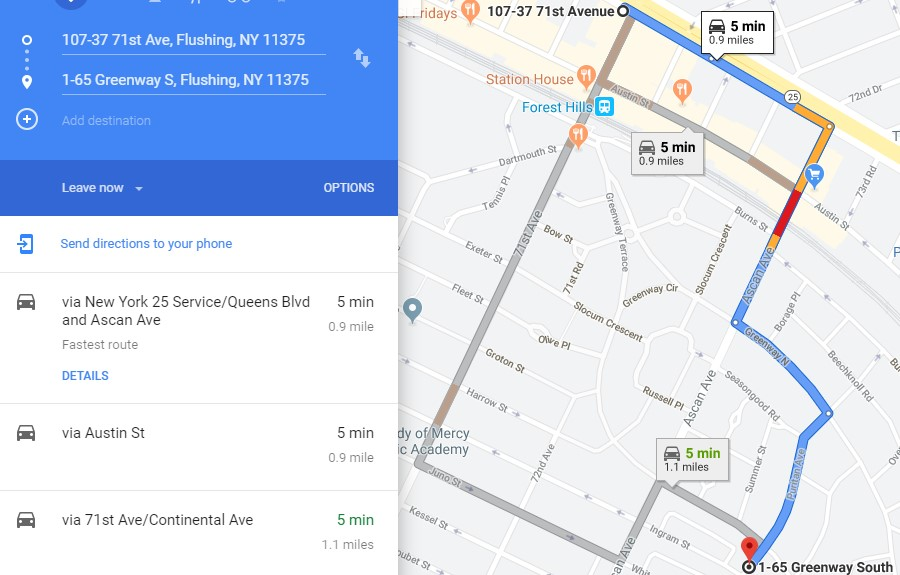

In [18]:
# A quick maps search for the first data point shows that the distance is 0.9 miles and hence the euclidean distance seems way off. So, I am going to keep the haversine distance in miles and remove the rest.
Image("Google Maps.jpg")

In [18]:
for data in [train, test]:
    data.drop(columns=['h_dist_kms','h_dist_eclu'], axis=1, inplace=True)

In [19]:
train.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,h_dist_miles
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.640487
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,5.250670
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0.863411
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,1.739386
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,1.242218


## EDA

In [20]:
# Let us calculate the average fare per miles
average_fare_per_mile = train.fare_amount.sum()/train.h_dist_miles.sum()
print(f'The average fare per miles is ${round(average_fare_per_mile,2)}')

The average fare per miles is $5.48


### Does the fare increases with distance? In general it should however, let us see it ourselves

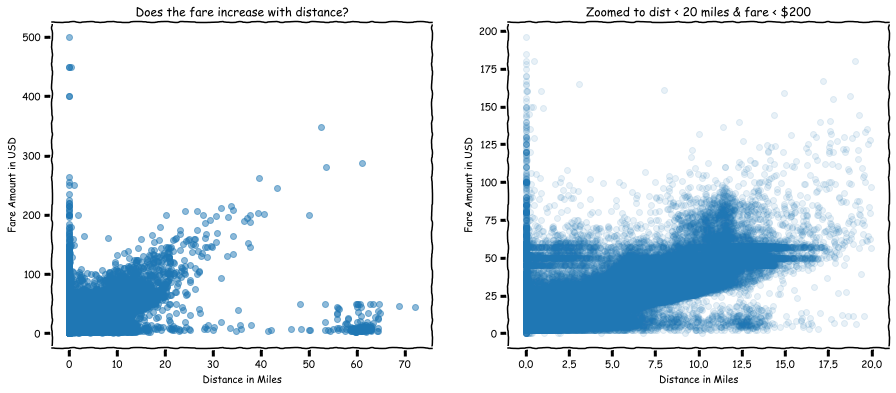

In [21]:

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].scatter(train.h_dist_miles, train.fare_amount, alpha=0.5)
ax[0].set_xlabel('Distance in Miles')
ax[0].set_ylabel('Fare Amount in USD')
ax[0].set_title('Does the fare increase with distance?')

short_rides = (train.h_dist_miles<20) & (train.fare_amount<200)

ax[1].scatter(train[short_rides].h_dist_miles, train[short_rides].fare_amount, alpha=0.1)
ax[1].set_xlabel('Distance in Miles')
ax[1].set_ylabel('Fare Amount in USD')
ax[1].set_title('Zoomed to dist < 20 miles & fare < $200');

##### From the plot above, it is fairly clear that fare increases with distance however, we found more interesting things here.
1. There are fairly huge number of rides with zero distance but high fair amount, this can be due to one of the two reasons:
    ** This may be due to some error during data acquisition where pickup and dropoff coordinates are same.
    ** These rides may be round trip rides that is the pickup and dropoff locations are same.
2. There looks to some horizontal lines in the second plot which means constant fare, this may be airport rides or something which are offered at fixed price.

In [22]:
# Let us see how many such rides are there where the distance is zero but fare is greater than zero
error_rides = train[(train.h_dist_miles == 0) & (train.fare_amount>0)].shape[0]
print(f'There are {error_rides} rides with zero distance and fare amount greater than zero')
train[(train.h_dist_miles == 0) & (train.fare_amount>0)].head()

There are 10523 rides with zero distance and fare amount greater than zero


,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,h_dist_miles
105,2009-03-25 00:08:52.0000001,52.0,-74.035839,40.747320,-74.035839,40.747320,1,2009,3,25,0,2,0.0
191,2014-01-08 21:55:58.0000006,6.5,-73.998488,40.726303,-73.998488,40.726303,1,2014,1,8,21,2,0.0
270,2012-08-25 01:53:42.0000005,7.5,-73.995892,40.746454,-73.995892,40.746454,1,2012,8,25,1,5,0.0
290,2009-12-14 12:33:00.00000075,6.9,-73.982432,40.745747,-73.982432,40.745747,1,2009,12,14,12,0,0.0
396,2014-03-12 18:12:44.0000006,12.0,-73.844904,40.736318,-73.844904,40.736318,1,2014,3,12,18,2,0.0


In [23]:
# Whoops!!! There are so many such rides and our guess was right. The pickup and dropoff location looks same for these rides. Let's remove these data points.
train = train[train.h_dist_miles>0]

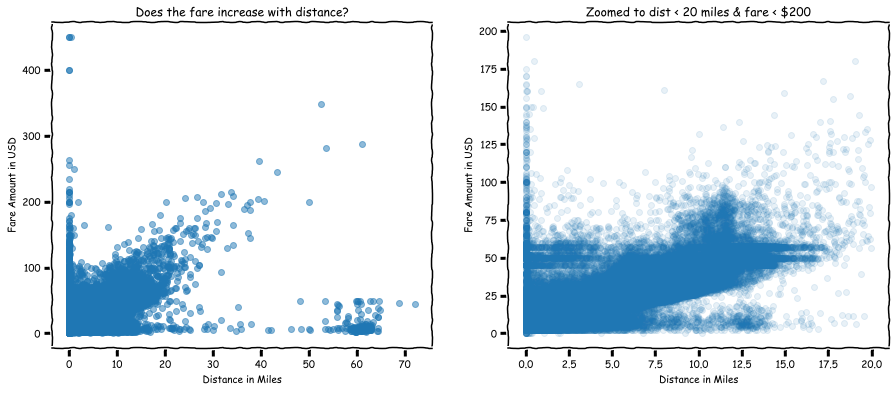

In [24]:
# Let us check the plot again if we can find some more hints

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].scatter(train.h_dist_miles, train.fare_amount, alpha=0.5)
ax[0].set_xlabel('Distance in Miles')
ax[0].set_ylabel('Fare Amount in USD')
ax[0].set_title('Does the fare increase with distance?')

short_rides = (train.h_dist_miles<20) & (train.fare_amount<200)

ax[1].scatter(train[short_rides].h_dist_miles, train[short_rides].fare_amount, alpha=0.1)
ax[1].set_xlabel('Distance in Miles')
ax[1].set_ylabel('Fare Amount in USD')
ax[1].set_title('Zoomed to dist < 20 miles & fare < $200');

In [25]:
# Looks like we still have a lot of rides with short distances and very high fair, let us see more.
train[['fare_amount', 'h_dist_miles']].sort_values(by='h_dist_miles')[:10]

,fare_amount,h_dist_miles
896586,45.00,0.000052
317039,85.00,0.000052
213867,80.00,0.000052
635121,57.33,0.000052
278861,58.00,0.000052
467688,12.22,0.000052
156251,4.50,0.000052
319814,16.00,0.000052
329570,2.50,0.000052
877508,2.50,0.000052


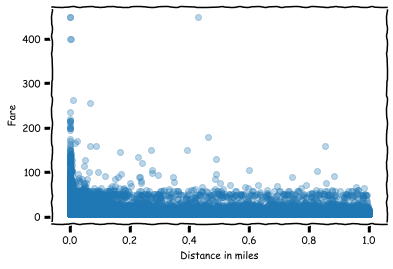

In [26]:
idx = (train.h_dist_miles<1) & (train.fare_amount>5)
plt.scatter(train[idx].h_dist_miles, train[idx].fare_amount, alpha=0.3)
plt.xlabel('Distance in miles')
plt.ylabel('Fare');
# The plot below gives us a clear picture that some very small rides have a very high fair. Let us drop them.

In [27]:
before = train.shape[0]
train = train[train.h_dist_miles>0.2]
after = train.shape[0]
print(f'Dropped {before-after} data points')

Dropped 13993 data points


## EDA - Passenger Count

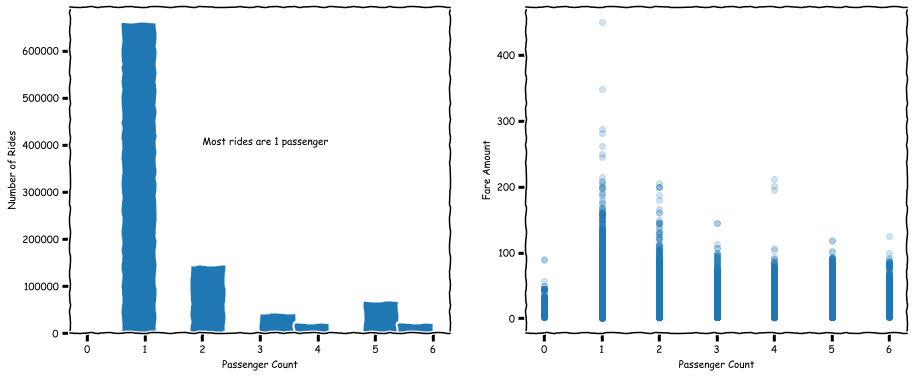

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].hist(train.passenger_count)
ax[0].set_xlabel('Passenger Count')
ax[0].set_ylabel('Number of Rides')
ax[0].annotate(xy=(2,400000), s='Most rides are 1 passenger')

ax[1].scatter(train.passenger_count, train.fare_amount, alpha=0.2)
ax[1].set_xlabel('Passenger Count')
ax[1].set_ylabel('Fare Amount');

# The plot shows that maximum rides are with 1 passenger and most fare seems to be coming from those rides.

## EDA - Year

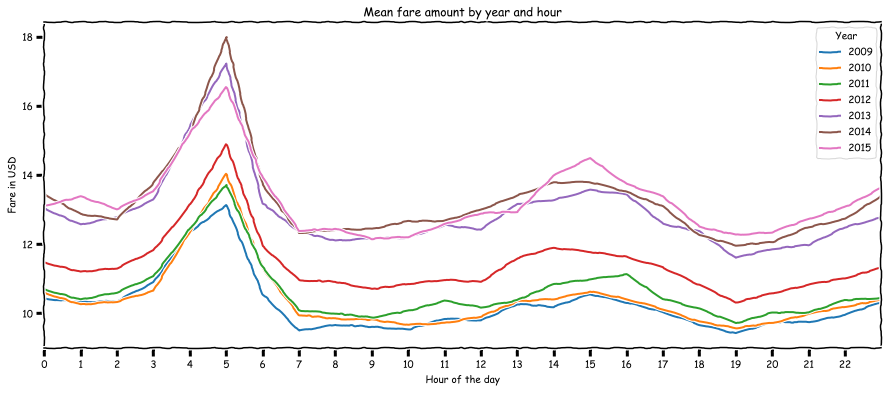

In [29]:
# Let us create a pivot table out of fare amount and year indexed by hour. Note that the pivot table is created with 'mean' as its aggregate function.
train.pivot_table(values='fare_amount', index='hour', columns='year').plot(figsize=(15,6))
plt.xticks(range(23))
plt.xlabel('Hour of the day')
plt.ylabel('Fare in USD')
plt.title('Mean fare amount by year and hour')
plt.legend(title='Year', loc='upper right');

#### The plot above clearly shows that fare amount varied slightly by year however there seems to be strong relationship with hour.
#### The plot shows mean fare amount and hence we cannot be sure of this hypothesis, so let us do some EDA with hour.

## EDA - Hour

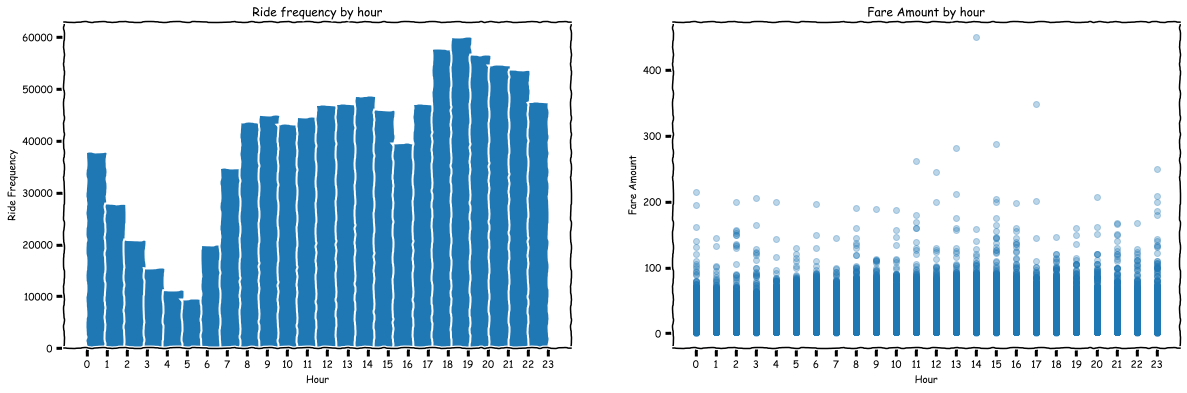

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].hist(train.hour, bins=24)
ax[0].set_xticks(range(24))
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Ride Frequency')
ax[0].set_title('Ride frequency by hour')

ax[1].scatter(train.hour, train.fare_amount, alpha=0.3)
ax[1].set_xticks(range(24))
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Fare Amount')
ax[1].set_title('Fare Amount by hour');

#### The first plot above shows a clear relationship that least number of rides are around 5 AM and number of rides increase as the day passes with maximum rides around 7-10 PM

# EDA - Day of Week

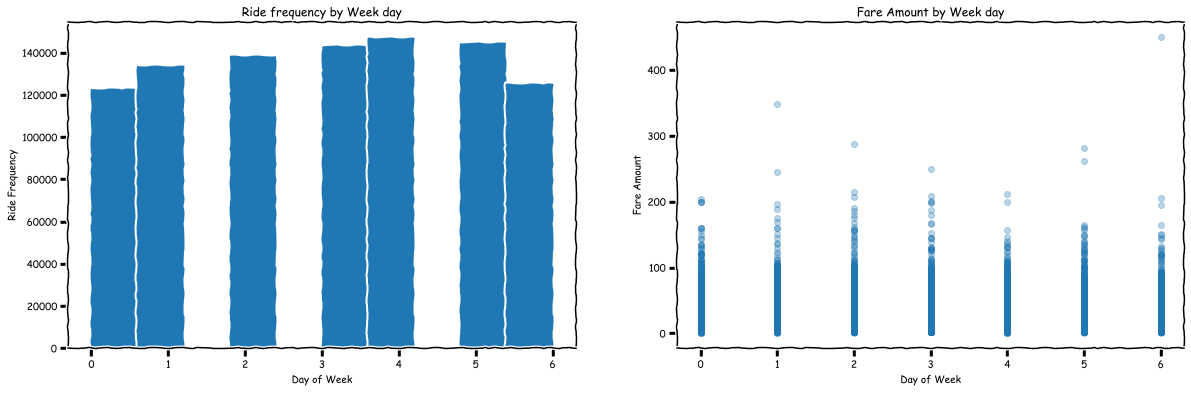

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].hist(train.day_of_week)
ax[0].set_xticks(range(7))
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Ride Frequency')
ax[0].set_title('Ride frequency by Week day')

ax[1].scatter(train.day_of_week, train.fare_amount, alpha=0.3)
ax[1].set_xticks(range(7))
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Fare Amount')
ax[1].set_title('Fare Amount by Week day');

# Seems like their is no strong relationship of number of rides and fare amount with what day of the week it is.

In [32]:
# Drop day of week from train and test
for data in [train, test]:
    data.drop(columns=['day_of_week'], axis=1, inplace=True)

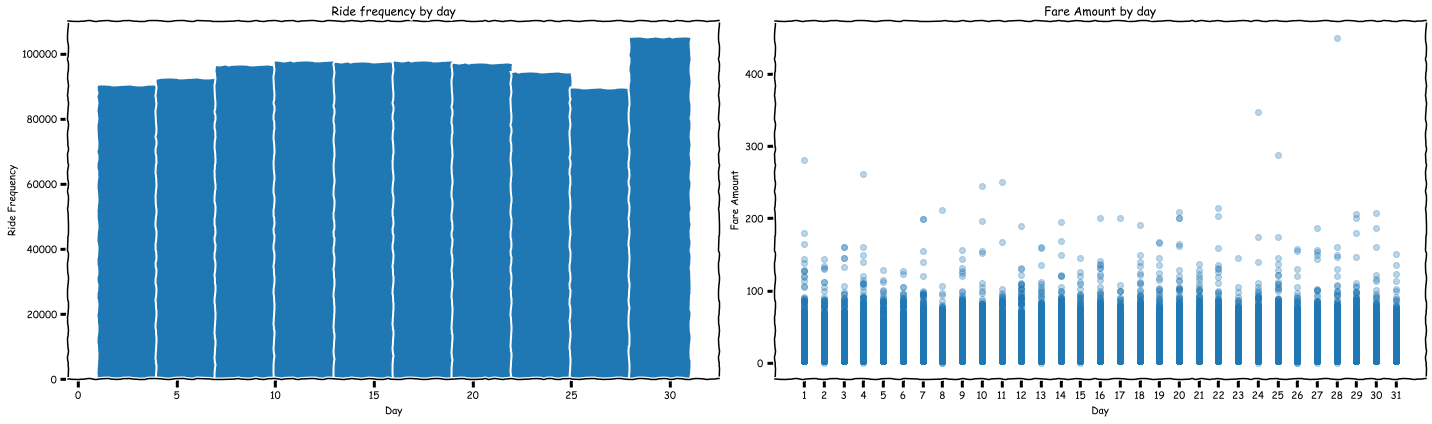

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].hist(train.day)
ax[0].set_xlabel('Day')
ax[0].set_ylabel('Ride Frequency')
ax[0].set_title('Ride frequency by day')

ax[1].scatter(train.day, train.fare_amount, alpha=0.3)
ax[1].set_xticks(range(1,32))
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Fare Amount')
ax[1].set_title('Fare Amount by day')
plt.tight_layout();

In [34]:
# Drop day from train and test
for data in [train, test]:
    data.drop(columns=['day'], axis=1, inplace=True)

In [35]:
train.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,hour,h_dist_miles
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,17,0.640487
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,16,5.250670
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,0,0.863411
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,4,1.739386
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,7,1.242218


In [36]:
X_train = train.drop(['key', 'fare_amount'], axis=1)
y_train = train['fare_amount']

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predictions = rf.predict(test.drop(['key'],axis=1))

C:\Users\ssolanki\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
submission = pd.read_csv('sample_submission.csv')
submission['fare_amount'] = predictions
submission.to_csv('submission_1.csv', index=False)
# This starter submission has achieved an RMSE of 3.4 which can certainly be improved with an in-depth model analysis and hyperparameter tuning.